# **Installation**

In [1]:
import pygam
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.cm as cm
from pygam import LinearGAM
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from edaUtils.featureEngineering import featureEngineering as fe

from textwrap import wrap
from matplotlib.cm import get_cmap

winter_palette = cm.get_cmap('winter', 256)
from bokeh.palettes import viridis
viridis_palette = viridis(256)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'

# **Save Players**

In [2]:
df = pd.read_csv("event-ttc-2011.txt", sep=';')
df.columns = df.columns.str.replace('\n', '')
Players = df[[' Player Number','Player Name']]
Players.rename(columns={' Player Number': 'ID'}, inplace=True)
Players.rename(columns={'Player Name': 'fullName'}, inplace=True)
Players.to_csv('Players.csv', index=None)

# **Data Import**

In [3]:
df = pd.read_csv("strokes.csv")

file_path = 'hole-ttc-2011.txt'
hole_df = pd.read_csv(file_path, delimiter=';')
hole_df.rename(columns={'Player #': 'player_id','Hole #': 'hole', 'Round #':'round'}, inplace=True)
temp_hole_df = hole_df
temp_hole_df = temp_hole_df[['player_id', 'hole', 'round', 'Time Hole Finished', 'Actual Yard']]

df = pd.merge(df, temp_hole_df, on=['player_id', 'hole', 'round'], how='inner')
df = df.drop_duplicates()

df['x'] = df['x'].str.replace(',', '').astype(float)
df['y'] = df['y'].str.replace(',', '').astype(float)

# **'Strokes to Hole Out'**

Most important feature of this project, allowing us to predict Expected Strokes

In [4]:
df['strokes_to_hole_out'] = df['hole_score'] - df['shot'] + df['num_of_strokes'] # df['num_of_strokes'] was 1

# **Z Scores Outliers**

In [5]:
z_scores = stats.zscore(df['strokes_to_hole_out'])
outliers = df[(z_scores < -3) | (z_scores > 3)]
print(f'Z Scores Outliers:')
outliers

Z Scores Outliers:


,tour_code,tour_description,year,tourn_id,player_id,course_id,permanent_tourn,first_name,last_name,round,...,elevation,slope,x,y,z,dist_from_center,dist_from_edge,Time Hole Finished,Actual Yard,strokes_to_hole_out
582,R,PGA TOUR,2011,410,20645,688,60,John,Senden,1,...,With,Level,8406.74,9986.92,509.702,920,521,13:47,374,7
11442,R,PGA TOUR,2011,410,25804,688,60,Bubba,Watson,3,...,With,Level,10559.44,9161.27,475.808,493,2,17:25,461,9
11444,R,PGA TOUR,2011,410,25804,688,60,Bubba,Watson,3,...,With,Level,10672.56,9692.34,477.002,497,256,17:25,461,8
11446,R,PGA TOUR,2011,410,25804,688,60,Bubba,Watson,3,...,With,Level,10559.72,9708.19,471.000,873,411,17:25,461,7
11634,R,PGA TOUR,2011,410,27095,688,60,Nick,Watney,3,...,With,Level,9190.43,8528.56,492.312,909,670,13:34,531,7
16538,R,PGA TOUR,2011,410,30925,688,60,Dustin,Johnson,4,...,With,Level,11618.58,8902.41,504.915,608,468,14:47,505,7


# **Interquartile Range Outliers**

In [6]:
Q1 = df['strokes_to_hole_out'].quantile(0.25)
Q3 = df['strokes_to_hole_out'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['strokes_to_hole_out'] < (Q1 - 1.5 * IQR)) | (df['strokes_to_hole_out'] > (Q3 + 1.5 * IQR))]
print(f'Interquartile Range Outliers:')
outliers

Interquartile Range Outliers:


,tour_code,tour_description,year,tourn_id,player_id,course_id,permanent_tourn,first_name,last_name,round,...,elevation,slope,x,y,z,dist_from_center,dist_from_edge,Time Hole Finished,Actual Yard,strokes_to_hole_out
582,R,PGA TOUR,2011,410,20645,688,60,John,Senden,1,...,With,Level,8406.74,9986.92,509.702,920,521,13:47,374,7
11442,R,PGA TOUR,2011,410,25804,688,60,Bubba,Watson,3,...,With,Level,10559.44,9161.27,475.808,493,2,17:25,461,9
11444,R,PGA TOUR,2011,410,25804,688,60,Bubba,Watson,3,...,With,Level,10672.56,9692.34,477.002,497,256,17:25,461,8
11446,R,PGA TOUR,2011,410,25804,688,60,Bubba,Watson,3,...,With,Level,10559.72,9708.19,471.000,873,411,17:25,461,7
11634,R,PGA TOUR,2011,410,27095,688,60,Nick,Watney,3,...,With,Level,9190.43,8528.56,492.312,909,670,13:34,531,7
16538,R,PGA TOUR,2011,410,30925,688,60,Dustin,Johnson,4,...,With,Level,11618.58,8902.41,504.915,608,468,14:47,505,7


# **Standard Scaler Outliers**

In [7]:
# Convert the pandas Series to a NumPy array
strokes_array = df['strokes_to_hole_out'].values.reshape(-1, 1)

# Scale the data
saleprice_scaled = StandardScaler().fit_transform(strokes_array)

# Sort and get the indices of the low and high ranges
sorted_indices = saleprice_scaled[:, 0].argsort()
low_indices = sorted_indices[:10]
high_indices = sorted_indices[-10:]

print('Standard Scaler Low Outliers:')
df.iloc[low_indices]

Standard Scaler Low Outliers:


,tour_code,tour_description,year,tourn_id,player_id,course_id,permanent_tourn,first_name,last_name,round,...,elevation,slope,x,y,z,dist_from_center,dist_from_edge,Time Hole Finished,Actual Yard,strokes_to_hole_out
3878,R,PGA TOUR,2011,410,30925,688,60,Dustin,Johnson,1,...,With,Level,0.0,0.0,0.0,0,0,17:56,477,-1
11462,R,PGA TOUR,2011,410,25804,688,60,Bubba,Watson,3,...,With,Level,0.0,0.0,0.0,0,0,17:25,461,-1
3742,R,PGA TOUR,2011,410,29221,688,60,Webb,Simpson,1,...,With,Level,0.0,0.0,0.0,0,0,18:12,459,0
15324,R,PGA TOUR,2011,410,24925,688,60,Jonathan,Byrd,4,...,With,Level,0.0,0.0,0.0,0,0,12:36,222,0
4628,R,PGA TOUR,2011,410,6567,688,60,Vijay,Singh,2,...,With,Level,0.0,0.0,0.0,0,0,12:58,202,0
10580,R,PGA TOUR,2011,410,24502,688,60,Adam,Scott,3,...,With,Level,0.0,0.0,0.0,0,0,17:42,461,0
10738,R,PGA TOUR,2011,410,24663,688,60,Y.E.,Yang,3,...,With,Level,0.0,0.0,0.0,0,0,15:48,209,0
9580,R,PGA TOUR,2011,410,22046,688,60,Geoff,Ogilvy,3,...,With,Level,0.0,0.0,0.0,0,0,16:03,446,0
7268,R,PGA TOUR,2011,410,26476,688,60,Chez,Reavie,2,...,With,Level,0.0,0.0,0.0,0,0,15:13,202,0
3332,R,PGA TOUR,2011,410,27095,688,60,Nick,Watney,1,...,With,Level,0.0,0.0,0.0,0,0,17:03,459,0


In [8]:
print('Standard Scaler High Outliers:')
df.iloc[high_indices]

Standard Scaler High Outliers:


,tour_code,tour_description,year,tourn_id,player_id,course_id,permanent_tourn,first_name,last_name,round,...,elevation,slope,x,y,z,dist_from_center,dist_from_edge,Time Hole Finished,Actual Yard,strokes_to_hole_out
3320,R,PGA TOUR,2011,410,27095,688,60,Nick,Watney,1,...,With,Level,10655.35,9193.64,480.268,634,198,17:03,459,6
11576,R,PGA TOUR,2011,410,26476,688,60,Chez,Reavie,3,...,With,Level,11472.93,8995.76,501.057,280,583,14:57,534,6
3292,R,PGA TOUR,2011,410,27095,688,60,Nick,Watney,1,...,With,Level,11355.06,9365.44,507.544,842,445,16:17,452,6
5584,R,PGA TOUR,2011,410,22405,688,60,Justin,Rose,2,...,With,Level,8201.84,9265.91,515.826,889,595,13:44,450,6
582,R,PGA TOUR,2011,410,20645,688,60,John,Senden,1,...,With,Level,8406.74,9986.92,509.702,920,521,13:47,374,7
11446,R,PGA TOUR,2011,410,25804,688,60,Bubba,Watson,3,...,With,Level,10559.72,9708.19,471.000,873,411,17:25,461,7
16538,R,PGA TOUR,2011,410,30925,688,60,Dustin,Johnson,4,...,With,Level,11618.58,8902.41,504.915,608,468,14:47,505,7
11634,R,PGA TOUR,2011,410,27095,688,60,Nick,Watney,3,...,With,Level,9190.43,8528.56,492.312,909,670,13:34,531,7
11444,R,PGA TOUR,2011,410,25804,688,60,Bubba,Watson,3,...,With,Level,10672.56,9692.34,477.002,497,256,17:25,461,8
11442,R,PGA TOUR,2011,410,25804,688,60,Bubba,Watson,3,...,With,Level,10559.44,9161.27,475.808,493,2,17:25,461,9


# **Discard Incorrect 'Strokes to Hole Out'**

For now...

In [9]:
#eventually Impute discarded values and sanity check 'Hole' Lies have a 'strokes_to_hole_out' value above 0

df['round_hole_combination'] = (df['round'] - 1) * 18 + df['hole']

df['bad_strokes_to_hole_out_value_flag'] = (df['strokes_to_hole_out'] <= 0)

#looks like .iloc 1939 and 5731 are the only messed up holes so thats a W!
selected_rows = df[df['bad_strokes_to_hole_out_value_flag']]


# Get the 'player_id' and 'round_hole_combination' for the selected rows
players_to_remove = selected_rows[['player_id', 'round_hole_combination']]

# Remove corresponding 'round_hole_combination' for each player
df = df.merge(players_to_remove, on=['player_id', 'round_hole_combination'], how='left', indicator=True)
df = df[df['_merge'] == 'left_only']

# Drop the indicator column and reset the index
df = df.drop(columns=['_merge']).reset_index(drop=True)


#--------------------------

#eventually Impute discarded values and sanity check 'Hole' Lies have a 'strokes_to_hole_out' value above 0

df['round_hole_combination'] = (df['round'] - 1) * 18 + df['hole']

df['bad_strokes_to_hole_out_value_flag'] = (df['from_location_scorer'] == 'Water')

#looks like .iloc 1939 and 5731 are the only messed up holes so thats a W!
selected_rows = df[df['bad_strokes_to_hole_out_value_flag']]


# Get the 'player_id' and 'round_hole_combination' for the selected rows
players_to_remove = selected_rows[['player_id', 'round_hole_combination']]

# Remove corresponding 'round_hole_combination' for each player
df = df.merge(players_to_remove, on=['player_id', 'round_hole_combination'], how='left', indicator=True)
df = df[df['_merge'] == 'left_only']

# Drop the indicator column and reset the index
df = df.drop(columns=['_merge']).reset_index(drop=True)

#--------------------------

#TODO: figure out how to use bad holes
# (df['strokes_to_hole_out'] == 0).sum()

# **Inches to Yards**

In [10]:
df['distance_to_pin'] = df['distance_to_pin']/36

df['dist_from_edge'] = df['dist_from_edge']/36

df['dist_from_center'] = df['dist_from_center']/36

df['dist_to_hole_after_shot'] = df['dist_to_hole_after_shot']/36

# **'Strokes to Hole Out' Poisson Distribution**

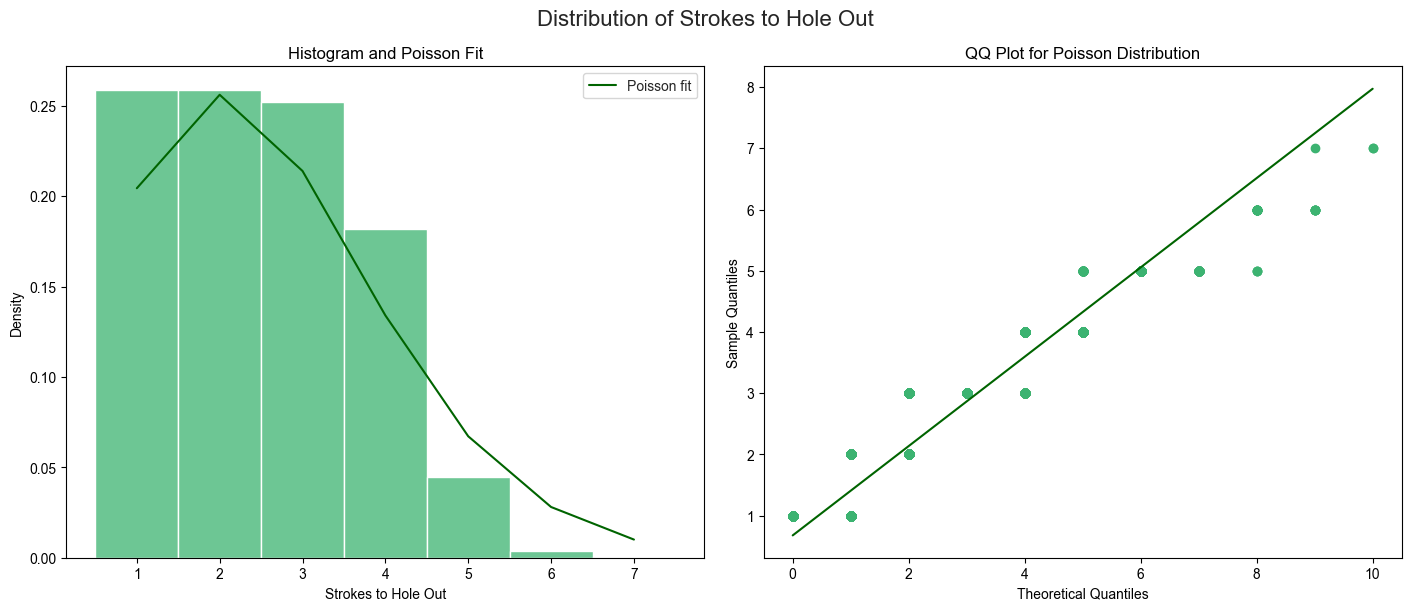

In [11]:
# Fit Poisson distribution
mu = df['strokes_to_hole_out'].mean()
poisson_dist = stats.poisson(mu)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

# Set a green color palette
sns.set_palette("Greens")
sns.set_style("whitegrid")

# Plot histogram and Poisson fit
sns.histplot(df['strokes_to_hole_out'], kde=False, stat='density', bins=range(int(df['strokes_to_hole_out'].min()), int(df['strokes_to_hole_out'].max()) + 1), discrete=True, ax=axes[0], color='mediumseagreen')
x = np.arange(df['strokes_to_hole_out'].min(), df['strokes_to_hole_out'].max() + 1)
axes[0].plot(x, poisson_dist.pmf(x), 'darkgreen', label='Poisson fit')
axes[0].legend()
axes[0].set_title('Histogram and Poisson Fit')
axes[0].set_xlabel('Strokes to Hole Out')
axes[0].set_ylabel('Density')

# QQ plot for Poisson distribution
res = stats.probplot(df['strokes_to_hole_out'], dist=stats.poisson, sparams=(mu,), plot=axes[1])
axes[1].get_lines()[1].set_color('darkgreen')  # Change the color of the QQ line
axes[1].get_lines()[0].set_markerfacecolor('mediumseagreen')  # Change the color of the QQ points
axes[1].get_lines()[0].set_markeredgecolor('mediumseagreen')  # Ensure points are consistently colored
axes[1].set_title('QQ Plot for Poisson Distribution')
axes[1].set_xlabel('Theoretical Quantiles')
axes[1].set_ylabel('Sample Quantiles')

plt.suptitle('Distribution of Strokes to Hole Out', fontsize=16)
plt.show()


# **'Strokes to Hole Out' Skewness**

In [12]:
print("Skewness: %f" % df['strokes_to_hole_out'].skew())

Skewness: 0.340551


# **'Strokes to Hole Out' Kurtosis**

In [13]:
print("Kurtosis: %f" % df['strokes_to_hole_out'].kurt())

Kurtosis: -0.773142


# **'Strokes to Hole Out' vs 'Distance to Pin'**

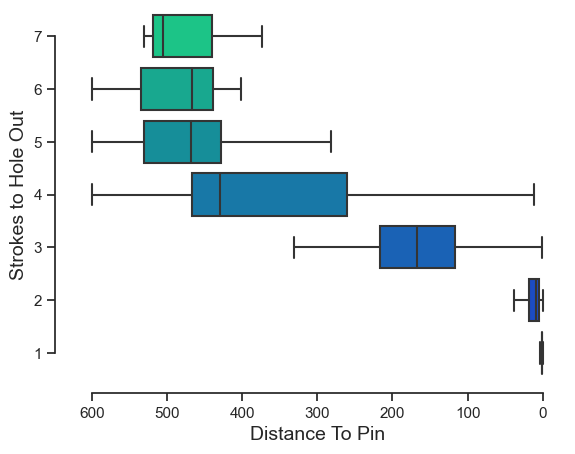

In [14]:
# [Whisker](https://docs.bokeh.org/en/latest/docs/examples/basic/annotations/whisker.html)

# [Ridgeplot](https://docs.bokeh.org/en/latest/docs/examples/topics/categorical/ridgeplot.html)

# Set Seaborn style
sns.set_theme(style="ticks", palette="pastel")

# Load the example tips dataset
tips = sns.load_dataset("tips")

# Draw a horizontal nested boxplot to show bills by day and time
ax = sns.boxplot(y="strokes_to_hole_out", x="distance_to_pin",
            #hue="lie_location", 
            palette='winter',
            data=df,
            orient="h",
            showfliers=False)
sns.despine(offset=10, trim=True)
ax.invert_yaxis()
ax.invert_xaxis()

# Set labels
plt.xlabel('Distance To Pin', fontsize=14)
plt.ylabel('Strokes to Hole Out', fontsize=14)

# Show the plot
plt.show()

# **'Strokes to Hole Out' vs 'Lie Location'**

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


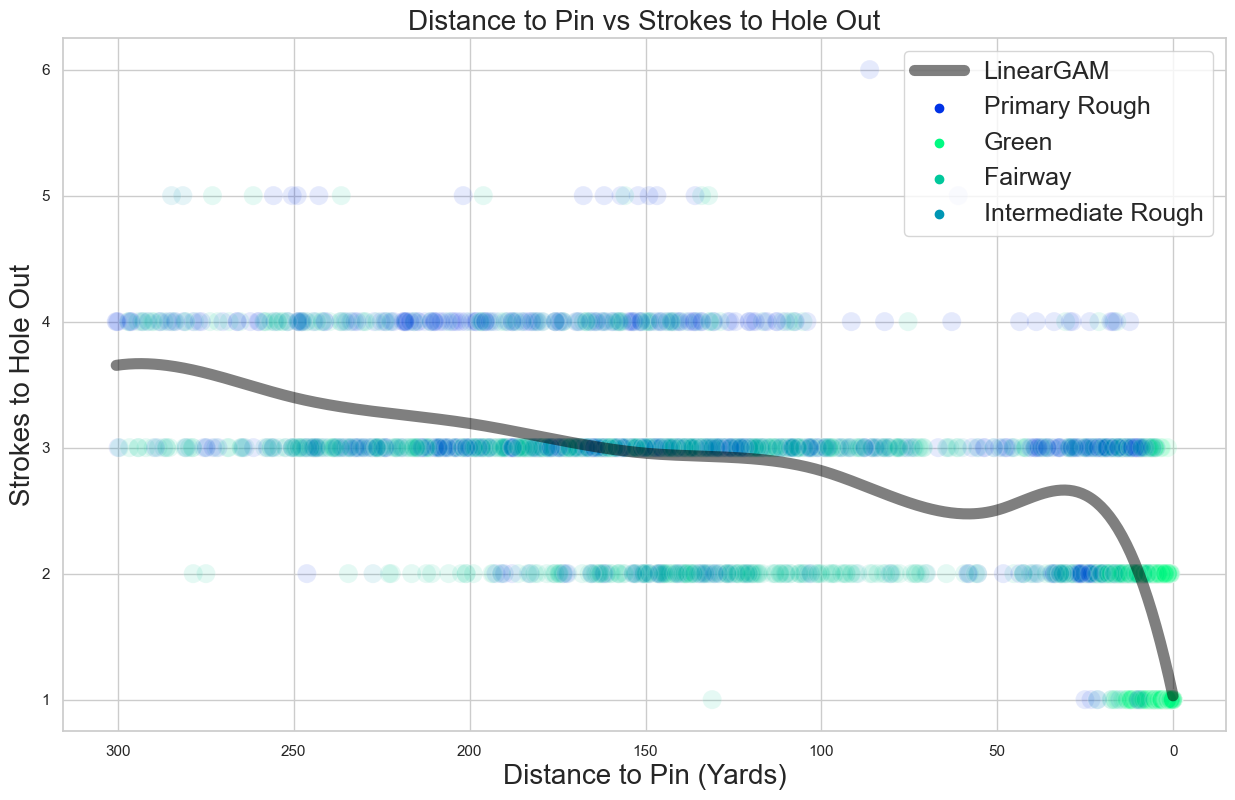

In [15]:
# Set Seaborn style
sns.set(style='whitegrid')

#ignore high level lies for viz
temp_df = df[df['from_location_scorer'] != 'Other']
temp_df = temp_df[temp_df['from_location_scorer'] != 'Native Area']
temp_df = temp_df[temp_df['from_location_scorer'] != 'Unknown']
temp_df = temp_df[temp_df['from_location_scorer'] != 'Water']
temp_df = temp_df[temp_df['from_location_scorer'] != 'Fringe']
temp_df = temp_df[temp_df['from_location_scorer'] != 'Fairway Bunker']
temp_df = temp_df[temp_df['from_location_scorer'] != 'Green Side Bunker']
temp_df = temp_df[temp_df['from_location_scorer'] != 'Tee Box']
temp_df = temp_df[temp_df['distance_to_pin'] <301]

# Define the indices for the colors
Pri_Rough_index = 50  # Adjust as needed
Intermediate_Rough_index = 150  # Adjust as needed
fairway_index = 200  # Adjust as needed
green_index = 250  # Adjust as needed

# Extract colors from the palette at the specified indices
Pri_Rough_index_hash = winter_palette(Pri_Rough_index)
Intermediate_Rough_index_hash = winter_palette(Intermediate_Rough_index)
fairway_index_hash = winter_palette(fairway_index)
green_index_hash = winter_palette(green_index)

custom_colors = {
    'Tee Box': 'black', 
    'Primary Rough': Pri_Rough_index_hash,
    'Intermediate Rough':Intermediate_Rough_index_hash, 
    'Fairway': fairway_index_hash,
    'Green': green_index_hash,}

# Create scatter plot with improved aesthetics
plt.figure(figsize=(15, 9))
ax = scatter_plot = sns.scatterplot(x='distance_to_pin', y='strokes_to_hole_out',alpha=0.1, hue='from_location_scorer', palette=custom_colors, data=temp_df, s=188)

numpy_array = temp_df['distance_to_pin'].values.reshape(-1, 1)
X = numpy_array
y = temp_df['strokes_to_hole_out']

# # ExpectileGAM
# gam50 = ExpectileGAM(expectile=0.5).gridsearch(X, y)
# XX = gam50.generate_X_grid(term=0, n=500)
# ax.plot(XX, gam50.predict(XX), label='ExpectileGAM',linewidth=8,alpha=0.50, color = 'red')

#LinearGAM
gam = LinearGAM(n_splines=9).gridsearch(X, y)
XX = gam.generate_X_grid(term=0, n=500)
ax.plot(XX, gam.predict(XX), label='LinearGAM',linewidth=8,alpha=0.50, color = 'black')

# Customize plot
ax.invert_xaxis()
plt.title('Distance to Pin vs Strokes to Hole Out', fontsize=20)
plt.xlabel('Distance to Pin (Yards)', fontsize=20)
plt.ylabel('Strokes to Hole Out', fontsize=20)
scatter_plot.legend(fontsize='18', loc='upper right')#title='Lie Location'

# Show the plot
plt.show()

# **Putting Features**

In [16]:
# distance to pin - distance to edge
df['pin_minus_edge'] = df['distance_to_pin'] - df['dist_from_edge']

# - distance to pin / distance to edge
df['pin_over_edge'] = (df['distance_to_pin']) /(df['dist_from_edge']) 

df['first_putt'] = df['first_putt'].fillna('No')

# **Non Putting Features**

In [17]:
# Short Sided Index
df['SSI'] = (df['distance_to_pin']-df['dist_from_edge'])/df['distance_to_pin']

# Center Sided Index
df['CSI'] = (df['distance_to_pin']-abs(df['dist_from_center']))/df['distance_to_pin']

# New 'Hole Completeness' feature
df['hole_completeness'] = 1 - df['distance_to_pin']/df['Actual Yard']

df['ISS'] = df['distance_to_pin']/(df['distance_to_pin']+abs(df['dist_from_edge']))

df['ISC'] = df['distance_to_pin']/(df['distance_to_pin']+abs(df['dist_from_center']))


# **Binning**

## **Putting Distance to Pin**

labels are ['0-1.25', '1.25-3.7743055555555554', '3.7743055555555554-601']
bins are [0, 1.25, 3.7743055555555554, 601]
Added putting_distance_to_pin_bins col


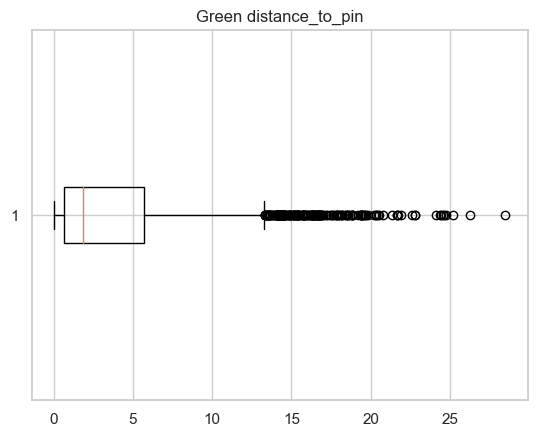

In [18]:
df = fe.binnig(df, True, 'distance_to_pin')

## **Non Putting Distance to Pin**

labels are ['0-163.90972222222223', '163.90972222222223-315.0138888888889', '315.0138888888889-601']
bins are [0, 163.90972222222223, 315.0138888888889, 601]
Added non_putting_distance_to_pin_bins col


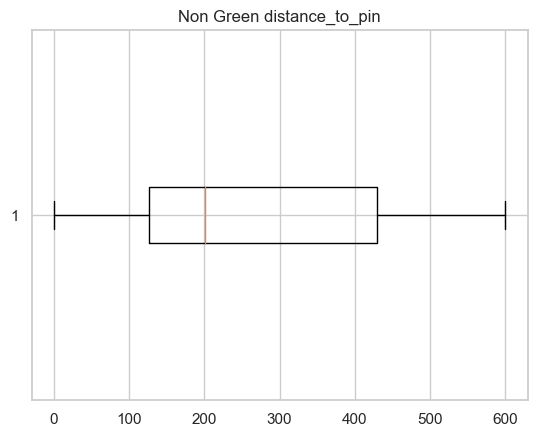

In [19]:
df = fe.binnig(df, False, 'distance_to_pin')

## **Putting Distance to Center**

labels are ['0.0-0.125', '0.125-601']
bins are [0.0, 0.125, 601]
Added putting_dist_from_center_bins col


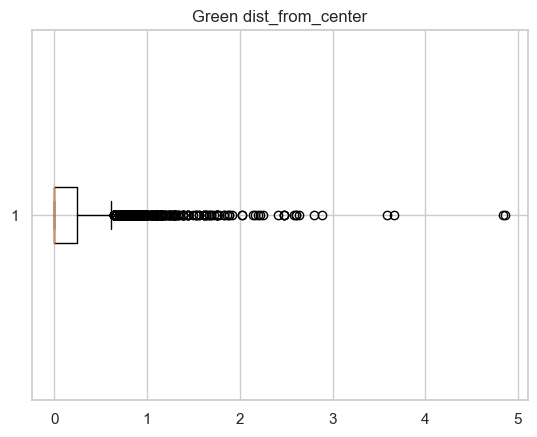

In [20]:
df = fe.binnig(df, True, 'dist_from_center')

## **Non Putting Distance to Center**

labels are ['0-3.666666666666667', '3.666666666666667-8.61111111111111', '8.61111111111111-601']
bins are [0, 3.666666666666667, 8.61111111111111, 601]
Added non_putting_dist_from_center_bins col


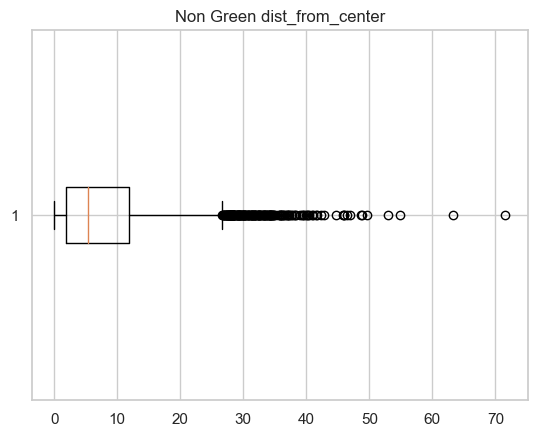

In [21]:
df = fe.binnig(df, False, 'dist_from_center')

## **Putting Distance to Edge**

labels are ['0.0-1.9583333333333333', '1.9583333333333333-601']
bins are [0.0, 1.9583333333333333, 601]
Added putting_dist_from_edge_bins col


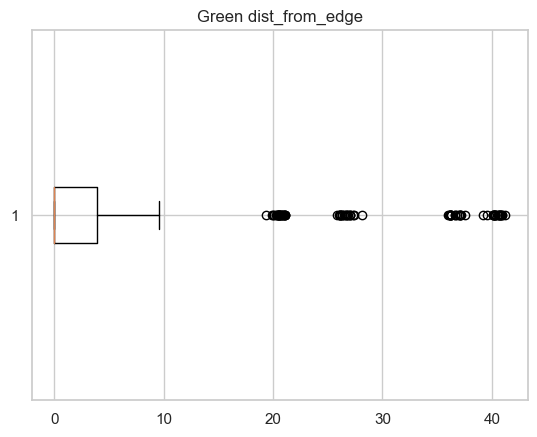

In [22]:
df = fe.binnig(df, True, 'dist_from_edge')

## **Non Putting Distance to Edge**

labels are ['0-3.888888888888889', '3.888888888888889-6.555555555555555', '6.555555555555555-601']
bins are [0, 3.888888888888889, 6.555555555555555, 601]
Added non_putting_dist_from_edge_bins col


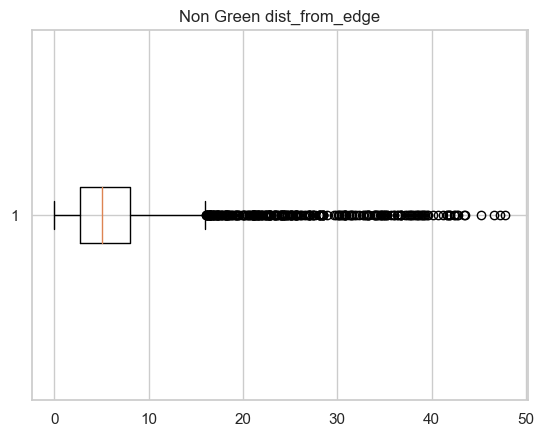

In [23]:
df = fe.binnig(df, False, 'dist_from_edge')

# **Hole Side**

In [24]:
# Create the new column 'side_of_hole'
df['side_of_hole'] = df['from_location_scorer'].apply(
    lambda x: 'L' if isinstance(x, str) and 'left' in x.lower() else ('R' if isinstance(x, str) and 'right' in x.lower() else 'N')
)

# **External Data**

In [25]:
#Dog_legs
Dog_legs = {1: 'R',2: 'N', 3: 'N', 4: 'L', 5: 'N', 6: 'R', 7: 'N', 8: 'N', 9: 'N', 10: 'N', 11: 'N', 12: 'N', 13: 'R', 14: 'R', 15: 'N', 16: 'L', 17: 'L', 18: 'L'}
df['dog_legs'] = df['hole'].map(Dog_legs)

#HCP
HCP = {1: 5,2: 17, 3: 13, 4: 11, 5: 3, 6: 9, 7: 1, 8: 7, 9: 15, 10: 8, 11: 18, 12: 12, 13: 4, 14: 10, 15: 16, 16: 2, 17: 14, 18: 6}
df['HCP'] = df['hole'].map(HCP)

#Golfer hand
righty_or_lefty = {    
    'Mickelson':'L',
    'Toms':'R',
    'Woodland':'R',
    'Simpson':'R',
    'Day':'R',
    'Snedeker':'R',
    'Watney':'R',
    'Reavie':'R',
    'Watson':'R',
    'Dufner':'R',
    'Byrd':'R',
    'Haas':'R',
    'Mahan':'R',
    'Yang':'R',
    'Scott':'R',
    'Choi':'R',
    'Donald':'R',
    'Van Pelt':'R',
    'Kuchar':'R',
    'Rose':'R',
    'Ogilvy':'R',
    'Howell III':'R',
    'Wilson':'R',
    'Jacobson':'R',
    'Senden':'R',
    'Singh':'R',
    'Johnson':'R',
    'Baddeley':'R',
    'Bradley':'R',
    'Stricker':'R'
}
df['golfer_hand'] = df['last_name'].map(righty_or_lefty)

# **Saving Feature Engineered Data**

In [26]:
df.to_csv('FE_golf.csv')